In [1]:
import pandas as pd
import numpy as np
import cv2

from PIL import Image, ImageStat
from matplotlib import pyplot as plt

In [2]:
def edge_detection(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
#     img = cv2.blur(img, (3,3))
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.Canny(img, threshold1=50, threshold2=200, apertureSize=5)
#     img = cv2.blur(img, (2,2))
    img = cv2.blur(img, (3,3))
    return img

In [3]:
# paths
path_icons = './icons/'
path_images = './images/'

In [86]:
# load inventory image
img_inventory = Image.open(path_images + 'inventar2.png')
img_inventory_np = np.asarray(img_inventory)

In [98]:
# edge detection
img_inventory_np_gray = cv2.cvtColor(img_inventory_np, cv2.COLOR_BGR2GRAY)
img_inventory_np_edge = edge_detection(img_inventory_np)

In [120]:
# slot detection
img_slot = Image.open(path_images + 'slot_empty.png')
img_slot_np = np.asarray(img_slot)
img_slot_np_gray = cv2.cvtColor(img_slot_np, cv2.COLOR_BGR2GRAY)
img_slot_np_edge = edge_detection(img_slot_np)


In [121]:
img = img_inventory_np_edge.copy()
img2 = img_inventory_np_edge.copy()

hor_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))

cv2.erode(img, hor_struct, img)
cv2.dilate(img, hor_struct, img)

ver_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))

cv2.erode(img2, ver_struct, img2)
cv2.dilate(img2, ver_struct, img2)

# result = cv2.bitwise_and(img, img2)
result = cv2.add(img, img2)

# kernel = np.array([[0, -1, 0],
#                    [-1, 5,-1],
#                    [0, -1, 0]])
# result = cv2.filter2D(src=result, ddepth=-1, kernel=kernel)

# result = cv2.blur(result, (5,5))
# (thresh, result) = cv2.threshold(result, 70, 255, cv2.THRESH_BINARY)

In [122]:
## template matching
# methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
#             'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
# res = []
# for meth in methods:
#     res.append(cv2.matchTemplate(result, img_slot_np_gray, eval(meth)))
# best = res[3]
best = cv2.matchTemplate(result, img_slot_np_gray, cv2.TM_CCORR_NORMED)

## find best positions
threshold = 0.7
img_slots = img_inventory_np.copy()
slots_mid = []
slots_right = []
slots_mid_min = (int) (1920/3)
slots_mid_max = 2000 #(int) (2*1920/3-90)
for y in range(best.shape[0]):
    for x in range(best.shape[1]):
        if best[y][x] > threshold:
#             img_slots = cv2.circle(img_slots, (x, y), radius=5, color=(255,0,0), thickness=-1)
            if x > slots_mid_min and x < slots_mid_max:
                slots_mid.append((x,y))
            elif x > slots_mid_max:
                slots_right.append((x,y))

In [123]:
min_distance = 50

new_slots = []
for x,y in slots_mid:
    add_slot = True
    for s in new_slots:
        if abs(s[0]-x) < min_distance and abs(s[1]-y) < min_distance:
            add_slot = False
            break
    if add_slot == True:
        new_slots.append((x,y))


img_slots = cv2.circle(img_slots, ((int) (1920/3), 100), radius=10, color=(0,255,0), thickness=-1)
img_slots = cv2.circle(img_slots, ((int) (2*1920/3-90), 100), radius=10, color=(0,255,0), thickness=-1)

In [124]:
for x,y in new_slots:
    img_slots = cv2.circle(img_slots, (x, y), radius=5, color=(255,0,0), thickness=-1)

In [130]:
slot_size = 64 # in pixels, for FHD resolution

items = []
for s in new_slots:
    #img_slots = cv2.rectangle(img_slots, s, (s[0]+slot_size, s[1]+slot_size), color=(0,255,0), thickness=-1)
    items.append(img_slots[s[1]:s[1]+slot_size, s[0]:s[0]+slot_size])
    

In [142]:
items_avg = []
for item in items:
    r = 0
    g = 0
    b = 0
    for x in range((int) (slot_size)):
        for y in range((int) (slot_size)):
            r += (item[y][x])[0]
            g += (item[y][x])[1]
            b += (item[y][x])[2]
    r = r / (slot_size)**2
    g = g / (slot_size)**2
    b = b / (slot_size)**2
    items_avg.append((r,g,b))

In [143]:
Image.fromarray(items[3])
(items[0])[0][0]
items_avg[0]

(59.9521484375, 56.234619140625, 41.753173828125)

In [127]:
# Image.fromarray(img_inventory_np_edge)

In [128]:
# Image.fromarray(result)

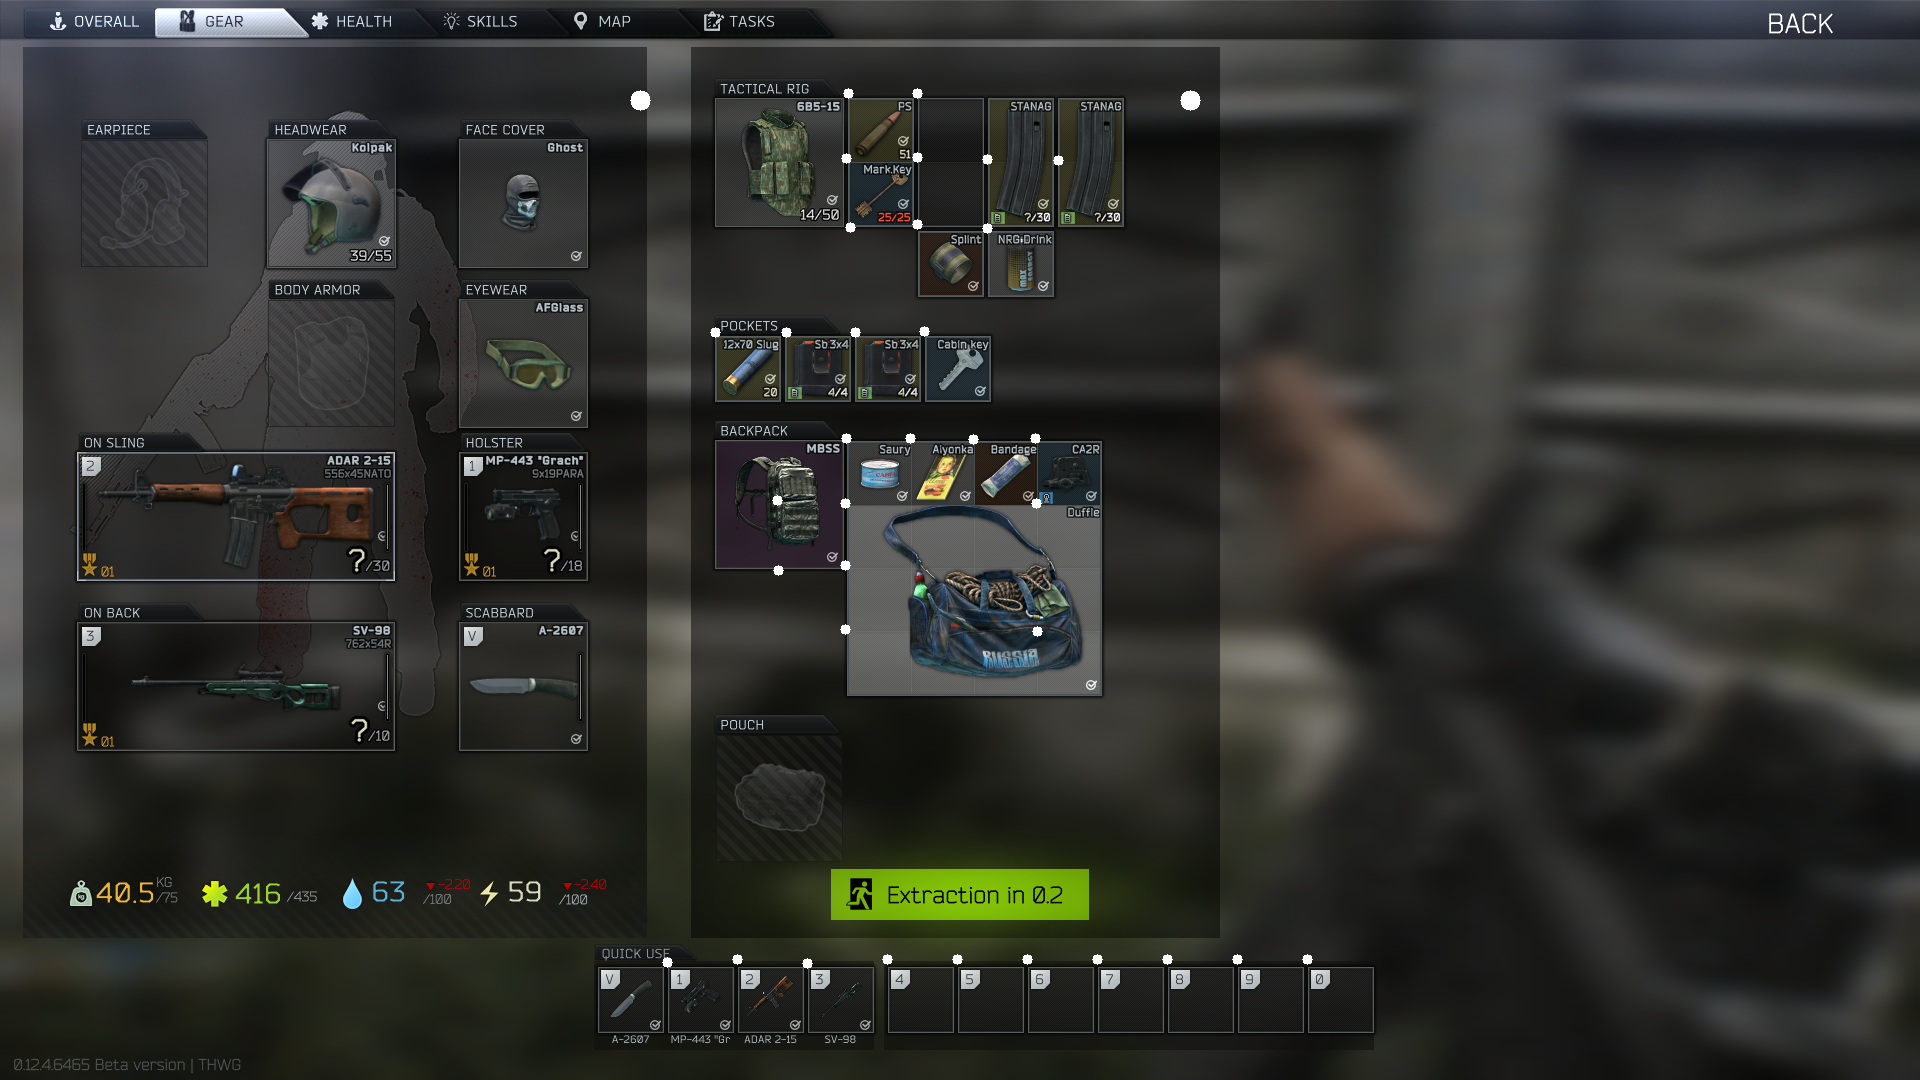

In [129]:
# Image.fromarray(img_slot_np_edge)
# Image.fromarray(res)
# plt.imshow(res[3], cmap='gray')
Image.fromarray(img_slots)
# Image.fromarray(hough)


In [138]:
2**3

8